# ECE 285 Final Project: Facial Expression Recognition
#### By Shivani Bhakta and Payal Singh 

# Imports

In [1]:
import glob
import numpy as np
import PIL
from PIL import Image, ImageOps, ImageEnhance, ImageFilter 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.datasets as dset
import torch.nn.functional as F
from torch.utils.data import sampler
from torch.utils.data import DataLoader, Dataset, TensorDataset

import os
import os.path as osp
import cv2 
import sys
import copy

from woodnet import *
from MyNet import *

## Crop and resize images
- We use the MTCNN face detector to recognize face in our dataset and crop each images and resize them to 224 x 224. Do this by running the PrepData.py file. Use the command ``` python PrepData.py``` in terminal
- We then store them into a new folder
- https://www.kaggle.com/timesler/guide-to-mtcnn-in-facenet-pytorch

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


## Tufts Face DB 
In this project we use a dataset named Tufts Face Database for Facial Recognition. This dataset is made up with over 10,000 images of 74 female and 38 males from more than 15 countries with the age range between 4-70 years old. This dataset contains 7 image modalities, but we only use a subset of it, from the Tufts Face Database 2D RGB Expression (TDRGBA). This set contains 5 images of 50 different people. These 5 images are of 5 different expressions (neutral, smiling, eyes closed, surprised, and sunglasses). 

## Visualize the dataset

In [ ]:
person = 1    # do not choose 47 (this participant withdrew from the dataset)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(24, 16))

if person == 47: 
    print('Cannot display Participant 47')
for idx in np.arange(1, 6):
    # original dataset images
    orig_im = Image.open(f'dataset/{person}/TD_RGB_E_{idx}.jpg')
    # cropped dataset images
    im = Image.open(f'cropped/TD_RGB_E_{person}_{idx}.jpg')
    # Display all of the images of selected person
    axes[idx-1][0].axis('off')
    axes[idx-1][0].imshow(orig_im)
    axes[idx-1][0].set_title(f'Original dataset: person {person}, image {idx}')
    axes[idx-1][1].axis('off')
    axes[idx-1][1].imshow(im)
    axes[idx-1][1].set_title(f'Cropped dataset: person {person}, image {idx}')

In [3]:
def get_faces():
    '''
    input: 
        n: number of images to load from the folder. 
    output: 
        neutral_faces: numpy array with each column corresponds to a data point (each image of neutral faces) 
        smiling_faces: numpy array with each column corresponds to a data point (each image of smiling faces)
    '''
    n = 49    # number of people in dataset
    
    neutral_faces = np.zeros((n,3,224,224))
    smiling_faces = np.zeros((n,3,224,224))
    eyesclosed_faces = np.zeros((n,3,224,224))
    surprised_faces = np.zeros((n,3,224,224))
    sunglasses_faces = np.zeros((n,3,224,224))

    for i in range(1,n+1):
        if i == 47: continue
        for j in range(1,6):
            image_path = f'cropped/TD_RGB_E_{i}_{j}.jpg'
            p = Image.open(image_path)
            # this is where to do data augmentation
            p = np.transpose(np.array(p))
        
            if j == 1: neutral_faces[i-1,:] = p
            elif j == 2: smiling_faces[i-1,:] = p
            elif j ==3: eyesclosed_faces[i-1,:] = p
            elif j == 4: surprised_faces[i-1,:] = p
            elif j == 5: sunglasses_faces[i-1,:] = p

    return neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces

neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces = get_faces()
print(neutral_faces.shape)

(49, 3, 224, 224)


In [4]:
def augmentation_and_transp(p):
    
    # flip image across vertical axis
    p1 = p.transpose(PIL.Image.FLIP_LEFT_RIGHT)
    # rotate images by 5 and 10 degrees to either side
    p2 = p.rotate(5)
    p3 = p.rotate(-5)
    p4 = p.rotate(10)
    p5 = p.rotate(-10)
    # change image brightness
    enhancer = ImageEnhance.Brightness(p)
    p6 = enhancer.enhance(0.5)
    p7 = enhancer.enhance(1.5)
    # Gaussian blur images
    p8 = p.filter(ImageFilter.GaussianBlur(radius = 5))
    # translate images to left/right/up/down 
#     p9 = p.transform(p.size, Image.AFFINE, (1, 0, 5, 0, 0, 5))
#     p10 = p.transform(p.size, Image.AFFINE, (1, 0, -5, 0, 0, -5))
#     p11 = p.transform(p.size, Image.AFFINE, (1, 0, 10, 0, 0, 10))
#     p12 = p.transform(p.size, Image.AFFINE, (1, 0, -10, 0, 0, -10))
    
    p9 = p.transform(p.size, Image.AFFINE, (1, 0, 5, 0, 1, 5))
    p10 = p.transform(p.size, Image.AFFINE, (1, 0, -5, 0,1, -5))
    p11 = p.transform(p.size, Image.AFFINE, (1, 0, 10, 0, 1, 10))
    p12 = p.transform(p.size, Image.AFFINE, (1, 0, -10, 0, 1, -10))
    # normalize
    p = np.transpose(np.array(p).astype('float32')/255.0)
    p1 = np.transpose(np.array(p1).astype('float32')/255.0)
    p2 = np.transpose(np.array(p2).astype('float32')/255.0)
    p3 = np.transpose(np.array(p3).astype('float32')/255.0)
    p4 = np.transpose(np.array(p4).astype('float32')/255.0)
    p5 = np.transpose(np.array(p5).astype('float32')/255.0)
    p6 = np.transpose(np.array(p6).astype('float32')/255.0)
    p7 = np.transpose(np.array(p7).astype('float32')/255.0)
    p8 = np.transpose(np.array(p8).astype('float32')/255.0)
    p9 = np.transpose(np.array(p9).astype('float32')/255.0)
    p10 = np.transpose(np.array(p10).astype('float32')/255.0)
    p11 = np.transpose(np.array(p11).astype('float32')/255.0)
    p12 = np.transpose(np.array(p12).astype('float32')/255.0)
    
    return p, p1,  p2,  p3, p4,  p5, p6, p7, p8, p9, p10, p11, p12

def get_faces1():
    '''
    input: 
        n: number of images to load from the folder. 
    output: 
        neutral_faces: numpy array with each column corresponds to a data point (each image of neutral faces) 
        smiling_faces: numpy array with each column corresponds to a data point (each image of smiling faces)
    '''
    n = 49    # number of people in dataset
    
    neutral_faces = []
    smiling_faces = []
    eyesclosed_faces = []
    surprised_faces = []
    sunglasses_faces = []

    for i in range(1,n+1):
        if i == 47: continue
        for j in range(1,6):
            image_path = f'cropped/TD_RGB_E_{i}_{j}.jpg'
            p = Image.open(image_path)
            p, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12 = augmentation_and_transp(p)    # data augmentation and transposing
        
            if j == 1: 
                neutral_faces.extend([p, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12])
            elif j == 2: 
                smiling_faces.extend([p, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12])
            elif j ==3: 
                eyesclosed_faces.extend([p, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12])
            elif j == 4: 
                surprised_faces.extend([p, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12])
            elif j == 5: 
                sunglasses_faces.extend([p, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12])

    return np.array(neutral_faces), np.array(smiling_faces), np.array(eyesclosed_faces), np.array(surprised_faces), np.array(sunglasses_faces)

neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces = get_faces1()
print(np.shape(neutral_faces))

(624, 3, 224, 224)


In [5]:
# dataset
data = np.vstack((neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces))
labels_0 = [0] * len(neutral_faces)
labels_1 = [1] * len(smiling_faces)
labels_2 = [2] * len(eyesclosed_faces)
labels_3 = [3] * len(surprised_faces)
labels_4 = [4] * len(sunglasses_faces)

labels = labels_0 + labels_1 + labels_2 + labels_3 + labels_4
labels = np.array(labels)
idxs = list(range(np.shape(neutral_faces)[0]*5))
np.random.shuffle(idxs)

data = data[idxs]
labels = labels[idxs]
print("Total data shape: ", data.shape)

test_train_split = 0.88889
train_data = data[:int(test_train_split * len(idxs))]
train_labels = labels[:int(test_train_split * len(idxs))]
print("Train data shape: ", train_data.shape)

test_data = data[int(test_train_split * len(idxs)):]
test_labels = labels[int(test_train_split * len(idxs)):]
print("Test data shape: ", test_data.shape)

image = test_data[0]
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
print("Individual Image size: ", image.shape)

Total data shape:  (3120, 3, 224, 224)
Train data shape:  (2773, 3, 224, 224)
Test data shape:  (347, 3, 224, 224)
Individual Image size:  (1, 3, 224, 224)


In [6]:
class MyDataset(Dataset):
    ''' This class formats the dataset into a iterable-style dataset needed for the dataloader'''
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)
        data = {'x': x, 'y': y}
        return data
    
    def __len__(self):
        return len(self.data)

train_data = MyDataset(train_data, train_labels)
test_data = MyDataset(test_data, test_labels)
# dataloader = DataLoader(dataset, batch_size=5)

# Model 

#### Create a function to check the accuracy 

In [7]:
NUM_TRAIN = len(train_data)
NUM_TEST = len(test_data)

def check_accuracy(loader, model):
  
    num_correct = 0
    num_samples = 0
    loss = 0.00
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for data in loader:
            x = data['x'].to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = data['y'].to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
            loss = F.cross_entropy(scores,y) + loss
            
        acc = float(num_correct) / num_samples
        loss = loss/ num_samples
        
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        
        return acc, loss

#### Create a function for training and validation 

In [8]:
def train_model(model, optimizer, epochs=1):
    """
    Train a model
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    loss_arr = []
    test_loss_arr = []
    test_acc_arr =[]
    model = model.to(device=device)  # move the model parameters to CPU/GPU
  
    for e in range(epochs):
        model.train() # put model to training mode
        for t, data in enumerate(loader_train):
            x = data['x'].to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = data['y'].to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()
            
            if t == 0:
                iter_loss = loss.item()
            else:
                iter_loss = iter_loss + loss.item()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print(f'Epoch {e}, Iteration {t}, loss = {loss.item():.7f}')
#                 acc_Val, loss_Val = check_accuracy(loader_val, model)
#                 print()
        loss_arr.append(iter_loss/t)
    
        model.eval()
        acc_Val, loss_Val = check_accuracy(loader_test, model)
        test_loss_arr.append(loss_Val)
        test_acc_arr.append(acc_Val)
    
    # plot loss and accuracy
    f, axes = plt.subplots(2, constrained_layout=True)
    axes[0].plot(loss_arr, label="Train loss")
#     axes[0].plot(test_loss_arr, label = 'Test loss')
    axes[0].set_title('Loss History')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[0].legend(loc='upper right')
    
    axes[1].plot(test_acc_arr, label="Test accuracy")
    axes[1].set_title('Accuracy History')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Accuracy')

In [9]:
loader_train = DataLoader(train_data, batch_size=12, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# loader_val = DataLoader(cifar100_val, batch_size=batch_size, num_workers=2, 
#                         sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

# cifar100_test = dset.CIFAR100('./datasets/cifar100', train=False, download=True, 
#                             transform=transform_test)
loader_test = DataLoader(test_data, batch_size=4)

## WoodNet

In [ ]:
# define WoodNet
model = WoodNet()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

print_every = 10
train_model(model, optimizer, epochs=50)
# without data augmentation, test accuracy was 20/28 ~= 71.4%
# with data augmentation and normalization, test accuracy was  ~= %

In [ ]:
# test set accuracy
check_accuracy(loader_test, model)

## MyNet

Epoch 0, Iteration 0, loss = 1.5948862
Epoch 0, Iteration 10, loss = 1.4240540
Epoch 0, Iteration 20, loss = 1.4412404
Epoch 0, Iteration 30, loss = 1.4615480
Epoch 0, Iteration 40, loss = 0.9442244
Epoch 0, Iteration 50, loss = 1.0433859
Epoch 0, Iteration 60, loss = 1.4166660
Epoch 0, Iteration 70, loss = 1.0442373
Epoch 0, Iteration 80, loss = 0.6835582
Epoch 0, Iteration 90, loss = 1.2977506
Epoch 0, Iteration 100, loss = 0.8426530
Epoch 0, Iteration 110, loss = 0.9819648
Epoch 0, Iteration 120, loss = 0.7738685
Epoch 0, Iteration 130, loss = 0.5957798
Epoch 0, Iteration 140, loss = 0.7498004
Epoch 0, Iteration 150, loss = 0.4894474
Epoch 0, Iteration 160, loss = 0.6577056
Epoch 0, Iteration 170, loss = 0.7171664
Epoch 0, Iteration 180, loss = 0.9381742
Epoch 0, Iteration 190, loss = 0.8437343
Epoch 0, Iteration 200, loss = 0.6729899
Epoch 0, Iteration 210, loss = 0.4850965
Epoch 0, Iteration 220, loss = 0.8414070
Epoch 0, Iteration 230, loss = 0.8311670
Got 82 / 347 correct (23.63

Epoch 8, Iteration 50, loss = 0.0033371
Epoch 8, Iteration 60, loss = 0.0636274
Epoch 8, Iteration 70, loss = 0.0220171
Epoch 8, Iteration 80, loss = 0.0057125
Epoch 8, Iteration 90, loss = 0.2818625
Epoch 8, Iteration 100, loss = 0.0528690
Epoch 8, Iteration 110, loss = 0.0251231
Epoch 8, Iteration 120, loss = 0.0840302
Epoch 8, Iteration 130, loss = 0.2248790
Epoch 8, Iteration 140, loss = 0.0264085
Epoch 8, Iteration 150, loss = 0.0051067
Epoch 8, Iteration 160, loss = 0.0137498
Epoch 8, Iteration 170, loss = 0.0358226
Epoch 8, Iteration 180, loss = 0.0001674
Epoch 8, Iteration 190, loss = 0.0068601
Epoch 8, Iteration 200, loss = 0.0035950
Epoch 8, Iteration 210, loss = 0.0376835
Epoch 8, Iteration 220, loss = 0.0101020
Epoch 8, Iteration 230, loss = 0.3592294
Got 217 / 347 correct (62.54)
Epoch 9, Iteration 0, loss = 0.0126276
Epoch 9, Iteration 10, loss = 0.0014852
Epoch 9, Iteration 20, loss = 0.0294608
Epoch 9, Iteration 30, loss = 0.0056264
Epoch 9, Iteration 40, loss = 0.00398

Epoch 16, Iteration 60, loss = 0.0073223
Epoch 16, Iteration 70, loss = 0.0024760
Epoch 16, Iteration 80, loss = 0.0327817
Epoch 16, Iteration 90, loss = 0.0025899
Epoch 16, Iteration 100, loss = 0.0032107
Epoch 16, Iteration 110, loss = 0.0030205
Epoch 16, Iteration 120, loss = 0.0010625
Epoch 16, Iteration 130, loss = 0.0034216
Epoch 16, Iteration 140, loss = 0.0043703
Epoch 16, Iteration 150, loss = 0.1172629
Epoch 16, Iteration 160, loss = 0.0000869
Epoch 16, Iteration 170, loss = 0.0008754
Epoch 16, Iteration 180, loss = 0.0002728
Epoch 16, Iteration 190, loss = 0.0174857
Epoch 16, Iteration 200, loss = 0.0126333
Epoch 16, Iteration 210, loss = 0.0218232
Epoch 16, Iteration 220, loss = 0.0685553
Epoch 16, Iteration 230, loss = 0.0504613
Got 226 / 347 correct (65.13)
Epoch 17, Iteration 0, loss = 0.0000377
Epoch 17, Iteration 10, loss = 0.0103486
Epoch 17, Iteration 20, loss = 0.0000120
Epoch 17, Iteration 30, loss = 0.0114880
Epoch 17, Iteration 40, loss = 0.0003147
Epoch 17, Iter

Epoch 24, Iteration 70, loss = 0.0032366
Epoch 24, Iteration 80, loss = 0.0125569
Epoch 24, Iteration 90, loss = 0.0010010
Epoch 24, Iteration 100, loss = 0.0010640
Epoch 24, Iteration 110, loss = 0.0709203
Epoch 24, Iteration 120, loss = 0.0000527
Epoch 24, Iteration 130, loss = 0.0005155
Epoch 24, Iteration 140, loss = 0.1793281
Epoch 24, Iteration 150, loss = 0.0049488
Epoch 24, Iteration 160, loss = 0.0000408
Epoch 24, Iteration 170, loss = 0.0000242
Epoch 24, Iteration 180, loss = 0.0001081
Epoch 24, Iteration 190, loss = 0.4792520
Epoch 24, Iteration 200, loss = 0.0006891
Epoch 24, Iteration 210, loss = 0.0004752
Epoch 24, Iteration 220, loss = 0.0243728
Epoch 24, Iteration 230, loss = 0.0001241
Got 219 / 347 correct (63.11)
Epoch 25, Iteration 0, loss = 0.0001076
Epoch 25, Iteration 10, loss = 0.0058086
Epoch 25, Iteration 20, loss = 0.0158452
Epoch 25, Iteration 30, loss = 0.0005496
Epoch 25, Iteration 40, loss = 0.0003225
Epoch 25, Iteration 50, loss = 0.0025862
Epoch 25, Iter

Epoch 32, Iteration 70, loss = 0.0000221
Epoch 32, Iteration 80, loss = 0.0005711
Epoch 32, Iteration 90, loss = 0.0000659
Epoch 32, Iteration 100, loss = 0.1263027
Epoch 32, Iteration 110, loss = 0.0021345
Epoch 32, Iteration 120, loss = 0.0000358
Epoch 32, Iteration 130, loss = 0.0000417
Epoch 32, Iteration 140, loss = 0.0009649
Epoch 32, Iteration 150, loss = 0.0000272
Epoch 32, Iteration 160, loss = 0.0101088
Epoch 32, Iteration 170, loss = 0.0006225
Epoch 32, Iteration 180, loss = 0.0001307
Epoch 32, Iteration 190, loss = 0.0027061
Epoch 32, Iteration 200, loss = 0.0035648
Epoch 32, Iteration 210, loss = 0.0000985
Epoch 32, Iteration 220, loss = 0.0000377
Epoch 32, Iteration 230, loss = 0.2272085
Got 238 / 347 correct (68.59)
Epoch 33, Iteration 0, loss = 0.0000736
Epoch 33, Iteration 10, loss = 0.0004687
Epoch 33, Iteration 20, loss = 0.2530938
Epoch 33, Iteration 30, loss = 0.0691204
Epoch 33, Iteration 40, loss = 0.0004034
Epoch 33, Iteration 50, loss = 0.0001426
Epoch 33, Iter

Epoch 40, Iteration 70, loss = 0.0065940
Epoch 40, Iteration 80, loss = 0.0008583
Epoch 40, Iteration 90, loss = 0.0006124
Epoch 40, Iteration 100, loss = 0.0004014
Epoch 40, Iteration 110, loss = 0.0004884
Epoch 40, Iteration 120, loss = 0.0001043
Epoch 40, Iteration 130, loss = 0.6666452
Epoch 40, Iteration 140, loss = 0.0001007
Epoch 40, Iteration 150, loss = 0.0004723
Epoch 40, Iteration 160, loss = 0.0028708
Epoch 40, Iteration 170, loss = 0.0000002
Epoch 40, Iteration 180, loss = 0.0007447
Epoch 40, Iteration 190, loss = 0.0008022
Epoch 40, Iteration 200, loss = 0.0000966
Epoch 40, Iteration 210, loss = 0.0000145
Epoch 40, Iteration 220, loss = 0.0001300
Epoch 40, Iteration 230, loss = 0.0000348
Got 249 / 347 correct (71.76)
Epoch 41, Iteration 0, loss = 0.0008223
Epoch 41, Iteration 10, loss = 0.0001586
Epoch 41, Iteration 20, loss = 0.0000671
Epoch 41, Iteration 30, loss = 0.0210486
Epoch 41, Iteration 40, loss = 0.0000006
Epoch 41, Iteration 50, loss = 0.0000182
Epoch 41, Iter

Epoch 48, Iteration 70, loss = 0.0000990
Epoch 48, Iteration 80, loss = 0.0006239
Epoch 48, Iteration 90, loss = 0.0001864
Epoch 48, Iteration 100, loss = 0.0001477
Epoch 48, Iteration 110, loss = 0.0000007
Epoch 48, Iteration 120, loss = 0.0004082
Epoch 48, Iteration 130, loss = 0.0005798
Epoch 48, Iteration 140, loss = 0.0000012
Epoch 48, Iteration 150, loss = 0.0002419
Epoch 48, Iteration 160, loss = 0.0000006
Epoch 48, Iteration 170, loss = 0.0000496
Epoch 48, Iteration 180, loss = 0.0000122
Epoch 48, Iteration 190, loss = 0.0049163
Epoch 48, Iteration 200, loss = 0.0027031
Epoch 48, Iteration 210, loss = 0.0000399
Epoch 48, Iteration 220, loss = 0.0000454
Epoch 48, Iteration 230, loss = 0.0100694
Got 244 / 347 correct (70.32)
Epoch 49, Iteration 0, loss = 0.0001623
Epoch 49, Iteration 10, loss = 0.0403408
Epoch 49, Iteration 20, loss = 0.0001111
Epoch 49, Iteration 30, loss = 0.0000022
Epoch 49, Iteration 40, loss = 0.0008576
Epoch 49, Iteration 50, loss = 0.0003376
Epoch 49, Iter

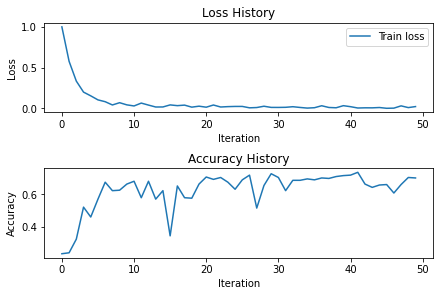

In [10]:
# define neural network
model = MyNet()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

print_every = 10
train_model(model, optimizer, epochs=50)

In [11]:
# test set accuracy
check_accuracy(loader_test, model)

Got 243 / 347 correct (70.03)


(0.7002881844380403, tensor(0.3135, device='cuda:0'))

## Try getting Pre-trained Model  

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.8.2', 'alexnet', pretrained=True)
model.eval()

# if torch.cuda.is_available():
#     train_data = train_data#.to('cuda')
#     model.to('cuda')
for t, data in enumerate(loader_train): 
    with torch.no_grad():
        output = model()
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
    print(output[0])
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    print(probabilities)

In [ ]:
# import torchvision
# vgg19 = torchvision.models.vgg19(pretrained=True)

# vgg19.classifier[1] = nn.Conv2d(vgg19.classifier[1].in_channels,5,1,1)

from torchvision import datasets, models, transforms
 
squeezenet = models.squeezenet1_1(pretrained=True, progress=True)
# Replace the last layer with one with the correct number of channels
network.load_state_dict
num_ftr = squeezenet.classifier[1].in_channels
squeezenet.classifier[1] = nn.Conv2d(num_ftr, 5, 1, 1)
# squeezenet

In [ ]:
from keras.applications.vgg16 import VGG16
model = VGG16()

from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
image = preprocess_input(image)

# predict the probability across all output classes
yhat = model.predict(image)

In [ ]:
def test(neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces, n): 
# def test(neutral_faces,smiling_faces,eyesclosed_faces, n): 
    '''
    Function to test that I am able to recontruct the original image with after all the reshaping and shaping.
    Checking the dimensions and shape as well. 
    '''
    print(neutral_faces.shape)

    plt.subplot(1,5,1)
    plt.imshow((neutral_faces[:,n]).reshape((224,224)))
    plt.subplot(1,5,2)
    plt.imshow((smiling_faces[:,n]).reshape((224,224)))
    plt.subplot(1,5,3)
    plt.imshow((eyesclosed_faces[:,n]).reshape((224,224)))
    plt.subplot(1,5,4)
    plt.imshow((surprised_faces[:,n]).reshape((224,224)))
    plt.subplot(1,5,5)
    plt.imshow((sunglasses_faces[:,n]).reshape((224,224)))

# Executing test function        
# test(neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces, 25)  

5/27 to do next:
- need dataloader
- figure out if data is already centered (if not, how to do it for PCA)
- feature extraction (PCA)
- train our ELMAN RNN (link for how to use RNN with Pytorch: https://www.kaggle.com/kanncaa1/recurrent-neural-network-with-pytorch, https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)
- find optimal weights
- test
- try out other types of netral networks

Reference* Any publication using this database must reference to this:
- Website: http://tdface.ece.tufts.edu/ and this
- Paper: Panetta, Karen, Qianwen Wan, Sos Agaian, Srijith Rajeev, Shreyas Kamath, Rahul Rajendran, Shishir Rao et al. "A comprehensive database for benchmarking imaging systems." IEEE Transactions on Pattern Analysis and Machine Intelligence (2018).
- R Vemulapalli, A Agarwala, “A Compact Embedding for Facial Expression Similarity”, CoRR, abs/1811.11283, 2018.